In [1]:
import datetime
import time

import pandas as pd
import seaborn as sns

from QueryMSC import workflow_tools

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"

In [3]:
start_time = datetime.datetime(2000, 1, 1)
end_time = datetime.datetime(2001, 1, 10)

msc = workflow_tools(connection_string, start_time, end_time, month=7)

In [4]:
precip = msc.annual_rain()

Year interval: 1.0


In [5]:
pd.read_sql(precip.statement, msc.engine).head()

,sum,max_date,min_date,lat,lon,station_id
0,1917.0,2001-01-10,2000-01-01,50.3332,-125.4460,176
1,377.8,2001-01-10,2000-01-01,50.4667,-106.0670,3953
2,697.4,2001-01-10,2000-01-01,48.5697,-81.3767,5468
3,856.3,2001-01-10,2000-01-01,49.7833,-97.1333,4831
4,342.5,2001-01-10,2000-01-01,58.7667,-111.1170,3610


In [6]:
variables = msc.query_variables()

In [7]:
pd.read_sql(variables.statement, msc.engine).head()

,vars_id,standard_name,long_description,unit
0,1401,,Hail,boolean
1,1424,,Smoke or Haze,boolean
2,1291,cloud_base_altitude,Ceiling currently observed,30s of meters
3,1292,visibility_in_air,Visibility currently observed,0.1 km
4,1293,air_pressure_at_sea_level,Sea level pressure,0.01 kPa


In [8]:
temp_25 = msc.design_temp_25_dry()
print(temp_25)

SELECT percentile_cont(%(percentile_cont_1)s) WITHIN GROUP (ORDER BY crmp.obs_raw.datum DESC) AS dry_temp, min(crmp.obs_raw.obs_time) AS time_min, max(crmp.obs_raw.obs_time) AS time_max, crmp.meta_history.lat AS crmp_meta_history_lat, crmp.meta_history.lon AS crmp_meta_history_lon, crmp.meta_history.station_id AS crmp_meta_history_station_id 
FROM crmp.meta_vars, crmp.obs_raw JOIN crmp.meta_history ON crmp.meta_history.history_id = crmp.obs_raw.history_id 
WHERE crmp.obs_raw.obs_time >= %(obs_time_1)s AND crmp.obs_raw.obs_time <= %(obs_time_2)s AND EXTRACT(month FROM crmp.obs_raw.obs_time) = %(param_1)s AND crmp.meta_vars.vars_id = %(vars_id_1)s GROUP BY crmp.meta_history.lat, crmp.meta_history.lon, crmp.meta_history.station_id


In [9]:
start = time.time()
df = pd.read_sql(temp_25.statement, msc.engine)
end = time.time()
print((end-start)/60., 'minutes', (end-start), 'seconds')

1.1952683965365092 minutes 71.71610379219055 seconds


In [10]:
df

,dry_temp,time_min,time_max,lat,lon,station_id
0,281.175,2000-07-01,2000-07-31 00:00:00,-104.7110,-104.7110,10674
1,228.000,2000-07-02,2000-07-31 00:00:00,41.8333,-82.4667,6103
2,257.250,2000-07-26,2000-07-27 00:00:00,42.0333,-82.9000,6037
3,287.000,2000-07-01,2000-07-31 00:00:00,42.0333,-82.9000,6138
4,283.250,2000-07-01,2000-07-31 00:00:00,42.0431,-82.6739,6040
5,290.000,2000-07-01,2000-07-31 00:00:00,42.1034,-83.0945,5992
6,288.150,2000-07-01,2000-07-31 00:00:00,42.2167,-82.7333,6137
7,230.000,2000-07-01,2000-07-31 23:00:00,42.2501,-81.9001,6141
8,253.025,2000-07-01,2000-07-31 23:00:00,42.2756,-82.9556,6130
9,252.000,2000-07-01,2000-07-31 23:00:00,42.3000,-82.7000,5997


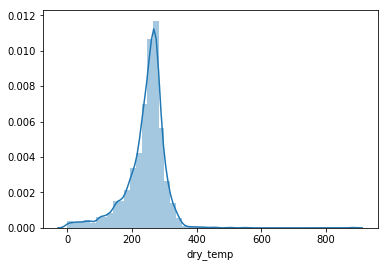

In [11]:
sns.distplot(df['dry_temp'])